In [24]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score, f1_score as sklearn_f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow.keras.backend as K

# --- New Imports for ResNet Architectures ---
from tensorflow.keras.applications import VGG16, ResNet50, ResNet101, ResNet152
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess_input
from tensorflow.keras.applications import DenseNet121, DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess_input
# --- End of New Imports ---


# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.1
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Appendicitis images: 1339
No appendicitis images: 1340
Total images: 2679


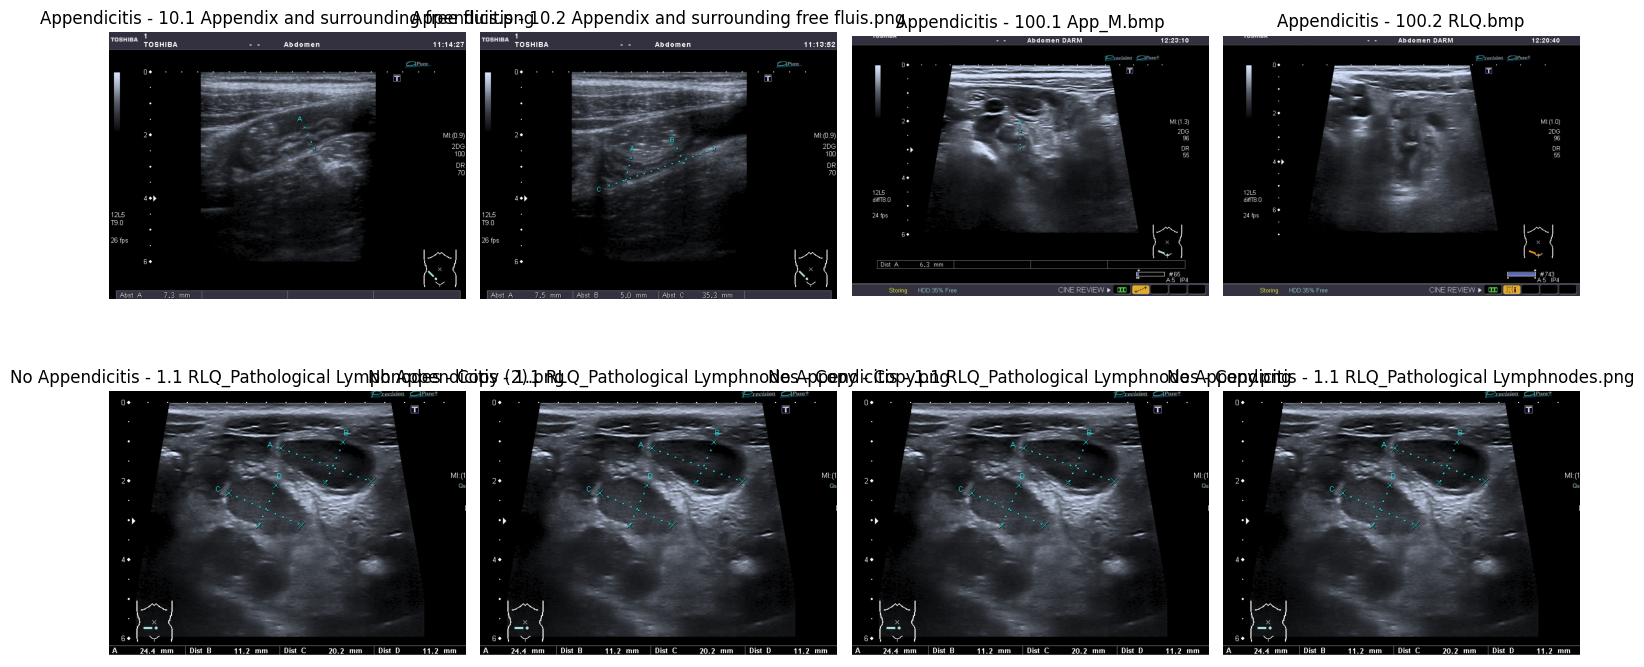

Loading appendicitis images...
Loading no appendicitis images...
Loaded 2679 images with shape: (2679, 224, 224, 3)
Labels distribution: [1340 1339]


In [25]:
# Define paths
# PLEASE ADJUST THESE PATHS IF YOUR DIRECTORY STRUCTURE IS DIFFERENT
appendicitis_path = "images-oversampling/appendicitis_images/"
no_appendicitis_path = "images-oversampling/no_appendicitis_images/"

# Function to load and explore dataset
def explore_dataset():
    # Count images in each category
    appendicitis_count = len([f for f in os.listdir(appendicitis_path) 
                             if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))])
    no_appendicitis_count = len([f for f in os.listdir(no_appendicitis_path) 
                                if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))])
    
    print(f"Appendicitis images: {appendicitis_count}")
    print(f"No appendicitis images: {no_appendicitis_count}")
    print(f"Total images: {appendicitis_count + no_appendicitis_count}")
    
    return appendicitis_count, no_appendicitis_count

appendicitis_count, no_appendicitis_count = explore_dataset()

def plot_sample_images(num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))
    
    # Plot appendicitis samples
    appendicitis_files = [f for f in os.listdir(appendicitis_path) 
                         if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    for i in range(min(num_samples, len(appendicitis_files))):
        img_path = os.path.join(appendicitis_path, appendicitis_files[i])
        img = Image.open(img_path)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].set_title(f'Appendicitis - {appendicitis_files[i]}')
        axes[0, i].axis('off')
    
    # Plot no appendicitis samples
    no_appendicitis_files = [f for f in os.listdir(no_appendicitis_path) 
                            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    for i in range(min(num_samples, len(no_appendicitis_files))):
        img_path = os.path.join(no_appendicitis_path, no_appendicitis_files[i])
        img = Image.open(img_path)
        axes[1, i].imshow(img, cmap='gray')
        axes[1, i].set_title(f'No Appendicitis - {no_appendicitis_files[i]}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_sample_images()

def load_and_preprocess_data(img_size=(224, 224)):
    """
    Load and preprocess images from both categories
    """
    images = []
    labels = []
    
    # Load appendicitis images (label = 1)
    print("Loading appendicitis images...")
    appendicitis_files = [f for f in os.listdir(appendicitis_path) 
                         if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    
    for filename in appendicitis_files:
        try:
            img_path = os.path.join(appendicitis_path, filename)
            img = Image.open(img_path)
            
            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Resize image
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]
            
            images.append(img_array)
            labels.append(1)  # Appendicitis
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    # Load no appendicitis images (label = 0)
    print("Loading no appendicitis images...")
    no_appendicitis_files = [f for f in os.listdir(no_appendicitis_path) 
                            if f.lower().endswith(('.bmp', '.jpg', '.jpeg', '.png'))]
    
    for filename in no_appendicitis_files:
        try:
            img_path = os.path.join(no_appendicitis_path, filename)
            img = Image.open(img_path)
            
            # Convert to RGB if needed
            if img.mode != 'RGB':
                img = img.convert('RGB')
            
            # Resize image
            img = img.resize(img_size)
            img_array = np.array(img) / 255.0  # Normalize to [0,1]
            
            images.append(img_array)
            labels.append(0)  # No appendicitis
            
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    
    return np.array(images), np.array(labels)

# Load the data
X, y = load_and_preprocess_data()
print(f"Loaded {len(X)} images with shape: {X.shape}")
print(f"Labels distribution: {np.bincount(y)}")

In [26]:
# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} images")
print(f"Validation set: {X_val.shape[0]} images")
print(f"Test set: {X_test.shape[0]} images")

# Check class distribution
print("\nClass distribution:")
print(f"Train - Appendicitis: {np.sum(y_train)}, No appendicitis: {len(y_train) - np.sum(y_train)}")
print(f"Val - Appendicitis: {np.sum(y_val)}, No appendicitis: {len(y_val) - np.sum(y_val)}")
print(f"Test - Appendicitis: {np.sum(y_test)}, No appendicitis: {len(y_test) - np.sum(y_test)}")

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

# No augmentation for validation and test sets
val_test_datagen = ImageDataGenerator()

# Calculate class weights to handle imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

print("\nClass weights:", class_weight_dict)
print(f"Weight for no appendicitis (class 0): {class_weight_dict[0]:.2f}")
print(f"Weight for appendicitis (class 1): {class_weight_dict[1]:.2f}")

Training set: 1875 images
Validation set: 402 images
Test set: 402 images

Class distribution:
Train - Appendicitis: 937, No appendicitis: 938
Val - Appendicitis: 201, No appendicitis: 201
Test - Appendicitis: 201, No appendicitis: 201

Class weights: {0: 0.9994669509594882, 1: 1.0005336179295625}
Weight for no appendicitis (class 0): 1.00
Weight for appendicitis (class 1): 1.00


In [27]:
def build_backbone_model(arch_name, input_shape=(224, 224, 3), base_trainable=False):
    """
    Returns the base model and its specific preprocessing function.
    arch_name: one of 'vgg16', 'resnet50', 'resnet101', 'resnet152'
    """
    arch_name = arch_name.lower()
    
    # A dictionary to hold our model classes and their preprocessing functions
    models = {
        "densenet121": (DenseNet121, densenet_preprocess_input),
        "densenet201": (DenseNet201, densenet_preprocess_input)
    }
    
    if arch_name not in models:
        raise ValueError(f"Unknown architecture: {arch_name}. Please choose from {list(models.keys())}")

    ModelClass, preprocess_fn = models[arch_name]
    
    base = ModelClass(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = base_trainable
    
    return base, preprocess_fn


def build_full_model(arch_name, input_shape=(224, 224, 3)):
    """
    Builds a complete model with a custom classifier on top of a pretrained backbone.
    """
    base_model, preprocess_fn = build_backbone_model(arch_name, input_shape=input_shape, base_trainable=False)
    
    x_input = keras.Input(shape=input_shape, name="input_image")
    
    # Preprocessing step
    if preprocess_fn:
        # ResNet models expect [0, 255] range. We scale our [0, 1] data back up.
        x = keras.layers.Lambda(lambda t: t * 255.0)(x_input)
        x = preprocess_fn(x)
    else:
        # VGG16 will use the [0, 1] data as is.
        x = x_input

    # Add the backbone
    x = base_model(x, training=False)  # Run backbone in inference mode
    
    # Add the custom classifier head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    output = layers.Dense(1, activation='sigmoid')(x)
    
    model = keras.Model(inputs=x_input, outputs=output)
    
    return model, base_model

# Let's test it by building one model to see the architecture
print("Building a ResNet50 model to test the function...")
test_model, _ = build_full_model('densenet201')
test_model.summary()
print("\nModel built successfully!")

Building a ResNet50 model to test the function...
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 lambda_6 (Lambda)           (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_12 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 tf.nn.bias_add_6 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_13 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
         

In [28]:
def f1_score(y_true, y_pred):
    """Custom macro F1 score for both classes."""
    def recall_class(y_true, y_pred, class_val):
        if class_val == 1:
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        else:  # class 0
            true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
            possible_negatives = K.sum(K.round(K.clip((1 - y_true), 0, 1)))
            return true_negatives / (possible_negatives + K.epsilon())
        return true_positives / (possible_positives + K.epsilon())

    def precision_class(y_true, y_pred, class_val):
        if class_val == 1:
            true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
            predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
            return true_positives / (predicted_positives + K.epsilon())
        else:  # class 0
            true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
            predicted_negatives = K.sum(K.round(K.clip((1 - y_pred), 0, 1)))
            return true_negatives / (predicted_negatives + K.epsilon())

    # Calculate F1 for class 0 (No Appendicitis)
    precision_0 = precision_class(y_true, y_pred, 0)
    recall_0 = recall_class(y_true, y_pred, 0)
    f1_0 = 2 * ((precision_0 * recall_0) / (precision_0 + recall_0 + K.epsilon()))
    
    # Calculate F1 for class 1 (Appendicitis)
    precision_1 = precision_class(y_true, y_pred, 1)
    recall_1 = recall_class(y_true, y_pred, 1)
    f1_1 = 2 * ((precision_1 * recall_1) / (precision_1 + recall_1 + K.epsilon()))
    
    # Return macro average F1 (average of both classes)
    return (f1_0 + f1_1) / 2.0

def compile_model_phase(model, learning_rate=1e-3, use_f1=True):
    """Compiles the model with a specific learning rate and metrics."""
    metrics_list = [
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')  # ADD AUC HERE
    ]
    if use_f1:
        metrics_list.append(f1_score)
        
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=metrics_list
    )

def get_callbacks(arch_name, phase, monitor_metric='val_accuracy'):
    """Creates a list of callbacks for a given training phase."""
    fname = f'best_{arch_name}_phase{phase}.keras'  # Use the modern .keras format
    return [
        EarlyStopping(
            monitor='val_loss',
            patience=8 if phase == 2 else 10,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3 if phase == 2 else 5,
            min_lr=1e-8,
            verbose=1
        ),
        ModelCheckpoint(
            fname,
            monitor=monitor_metric,
            mode='max',
            save_best_only=True,
            verbose=1
        )
    ]

def unfreeze_for_finetune(base_model, arch_name):
    """
    Unfreezes a reasonable fraction of the backbone layers for fine-tuning,
    depending on the architecture type.
    """
    arch_name = arch_name.lower()

    if 'resnet' in arch_name:
        # For ResNets, unfreeze from last convolutional block
        layers_to_unfreeze = {
            'resnet50': 22,
            'resnet101': 22,
            'resnet152': 55
        }.get(arch_name, 22)
        
        for layer in base_model.layers[:-layers_to_unfreeze]:
            layer.trainable = False
        for layer in base_model.layers[-layers_to_unfreeze:]:
            layer.trainable = True

    elif 'vgg' in arch_name:
        # For VGG, unfreeze last conv block
        for layer in base_model.layers[:-4]:
            layer.trainable = False
        for layer in base_model.layers[-4:]:
            layer.trainable = True

    elif 'dense' in arch_name:
        # For DenseNet, unfreeze top ~30% of layers
        unfreeze_from = int(len(base_model.layers) * 0.7)
        for layer in base_model.layers[:unfreeze_from]:
            layer.trainable = False
        for layer in base_model.layers[unfreeze_from:]:
            layer.trainable = True

    else:
        # Fallback: unfreeze last 20% of layers
        unfreeze_from = int(len(base_model.layers) * 0.8)
        for layer in base_model.layers[:unfreeze_from]:
            layer.trainable = False
        for layer in base_model.layers[unfreeze_from:]:
            layer.trainable = True
        
def evaluate_and_report(model, X_data, y_data, set_name="Validation"):
    """Predicts, evaluates, and prints a classification report."""
    predictions = model.predict(X_data, verbose=0)
    binary_predictions = (predictions > 0.5).astype(int).ravel()
    
    # Classification report
    report = classification_report(y_data, binary_predictions, target_names=['No Appendicitis', 'Appendicitis'], output_dict=False)
    print(f"\n--- {set_name} Classification Report ---")
    print(report)
    
    # Confusion matrix
    cm = confusion_matrix(y_data, binary_predictions)
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    sensitivity = tp / (tp + fn + 1e-7)
    specificity = tn / (tn + fp + 1e-7)
    
    # Calculate F1 scores for both classes
    f1_class_0 = sklearn_f1_score(y_data, binary_predictions, pos_label=0)  # No Appendicitis
    f1_class_1 = sklearn_f1_score(y_data, binary_predictions, pos_label=1)  # Appendicitis
    f1_macro = sklearn_f1_score(y_data, binary_predictions, average='macro')  # Macro average
    
    # Calculate AUC
    auc_score = roc_auc_score(y_data, predictions)
    
    print(f"Sensitivity (Recall): {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"F1-Score (No Appendicitis): {f1_class_0:.3f}")
    print(f"F1-Score (Appendicitis): {f1_class_1:.3f}")
    print(f"F1-Score (Macro Average): {f1_macro:.3f}")
    print(f"AUC: {auc_score:.3f}")
    print("------------------------------------")
    
    return {
        "confusion_matrix": cm,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "f1_class_0": f1_class_0,
        "f1_class_1": f1_class_1,
        "f1_macro": f1_macro,
        "auc": auc_score,
        "classification_report": report
    }
print("Training utility functions defined successfully.")

Training utility functions defined successfully.


In [29]:
# A list of all model architectures we want to train
architectures = ['densenet121', 'densenet201']
all_results = {}

# Ensure labels are float32 for Keras
y_train_float = y_train.astype('float32')
y_val_float   = y_val.astype('float32')
y_test_float  = y_test.astype('float32')

for arch in architectures:
    print(f"\n==============================================")
    print(f"  TRAINING ARCHITECTURE: {arch.upper()}  ")
    print(f"==============================================")
    
    # 1. Build the model
    model, base_model = build_full_model(arch, input_shape=(224, 224, 3))
    
    # --- PHASE 1: TRANSFER LEARNING ---
    print("\n--- Starting Phase 1: Training top layers (backbone frozen) ---")
    
    # Compile with a higher learning rate
    compile_model_phase(model, learning_rate=1e-3, use_f1=True)
    
    # Get callbacks for this phase
    callbacks_phase1 = get_callbacks(arch, phase=1, monitor_metric='val_accuracy')
    
    print(f"Backbone trainable layers: {sum(1 for l in base_model.layers if l.trainable)} / {len(base_model.layers)}")
    
    history_phase1 = model.fit(
        train_datagen.flow(X_train, y_train_float, batch_size=32),
        epochs=20,
        validation_data=(X_val, y_val_float),
        class_weight=class_weight_dict,
        callbacks=callbacks_phase1,
        verbose=1
    )
    
    # --- PHASE 2: FINE-TUNING ---
    print("\n--- Starting Phase 2: Fine-tuning backbone ---")
    
    # Unfreeze the top layers of the base model
    unfreeze_for_finetune(base_model, arch)
    print(f"After unfreezing, trainable layers in backbone: {sum(1 for l in base_model.layers if l.trainable)} / {len(base_model.layers)}")
    
    # Re-compile with a much lower learning rate for fine-tuning
    compile_model_phase(model, learning_rate=1e-5, use_f1=True)
    
    # Get new callbacks for phase 2
    callbacks_phase2 = get_callbacks(arch, phase=2, monitor_metric='val_accuracy')
    
    history_phase2 = model.fit(
        train_datagen.flow(X_train, y_train_float, batch_size=16), # Smaller batch size for fine-tuning
        epochs=15,
        validation_data=(X_val, y_val_float),
        class_weight=class_weight_dict,
        callbacks=callbacks_phase2,
        verbose=1
    )
    
    # --- FINAL EVALUATION ---
    # The best weights from phase 2 are already restored by the EarlyStopping callback
    print(f"\n--- Final Evaluation for {arch.upper()} ---")
    
    # Evaluate on the validation set
    val_eval = evaluate_and_report(model, X_val, y_val, set_name=f"{arch.upper()} Final Validation")
    
    # Evaluate on the unseen test set
    test_eval = evaluate_and_report(model, X_test, y_test, set_name=f"{arch.upper()} Final Test")
    
    # Store all results for this architecture
    all_results[arch] = {
        "history_phase1": history_phase1.history,
        "history_phase2": history_phase2.history,
        "validation_evaluation": val_eval,
        "test_evaluation": test_eval
    }

print("\n\nAll training and evaluation complete!")


  TRAINING ARCHITECTURE: DENSENET121  

--- Starting Phase 1: Training top layers (backbone frozen) ---
Backbone trainable layers: 0 / 427
Epoch 1/20
59/59 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.6245 - precision: 0.6249 - recall: 0.6222 - auc: 0.6759 - f1_score: 0.6178
Epoch 1: val_accuracy improved from -inf to 0.63184, saving model to best_densenet121_phase1.keras
59/59 [==============================] - 16s 219ms/step - loss: 0.6983 - accuracy: 0.6245 - precision: 0.6249 - recall: 0.6222 - auc: 0.6759 - f1_score: 0.6178 - val_loss: 0.6491 - val_accuracy: 0.6318 - val_precision: 0.5957 - val_recall: 0.8209 - val_auc: 0.7127 - val_f1_score: 0.6113 - lr: 0.0010
Epoch 2/20
59/59 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.6779 - precision: 0.6785 - recall: 0.6756 - auc: 0.7442 - f1_score: 0.6693
Epoch 2: val_accuracy did not improve from 0.63184
59/59 [==============================] - 12s 203ms/step - loss: 0.6157 - accuracy


--- Training History for DENSENET121 ---


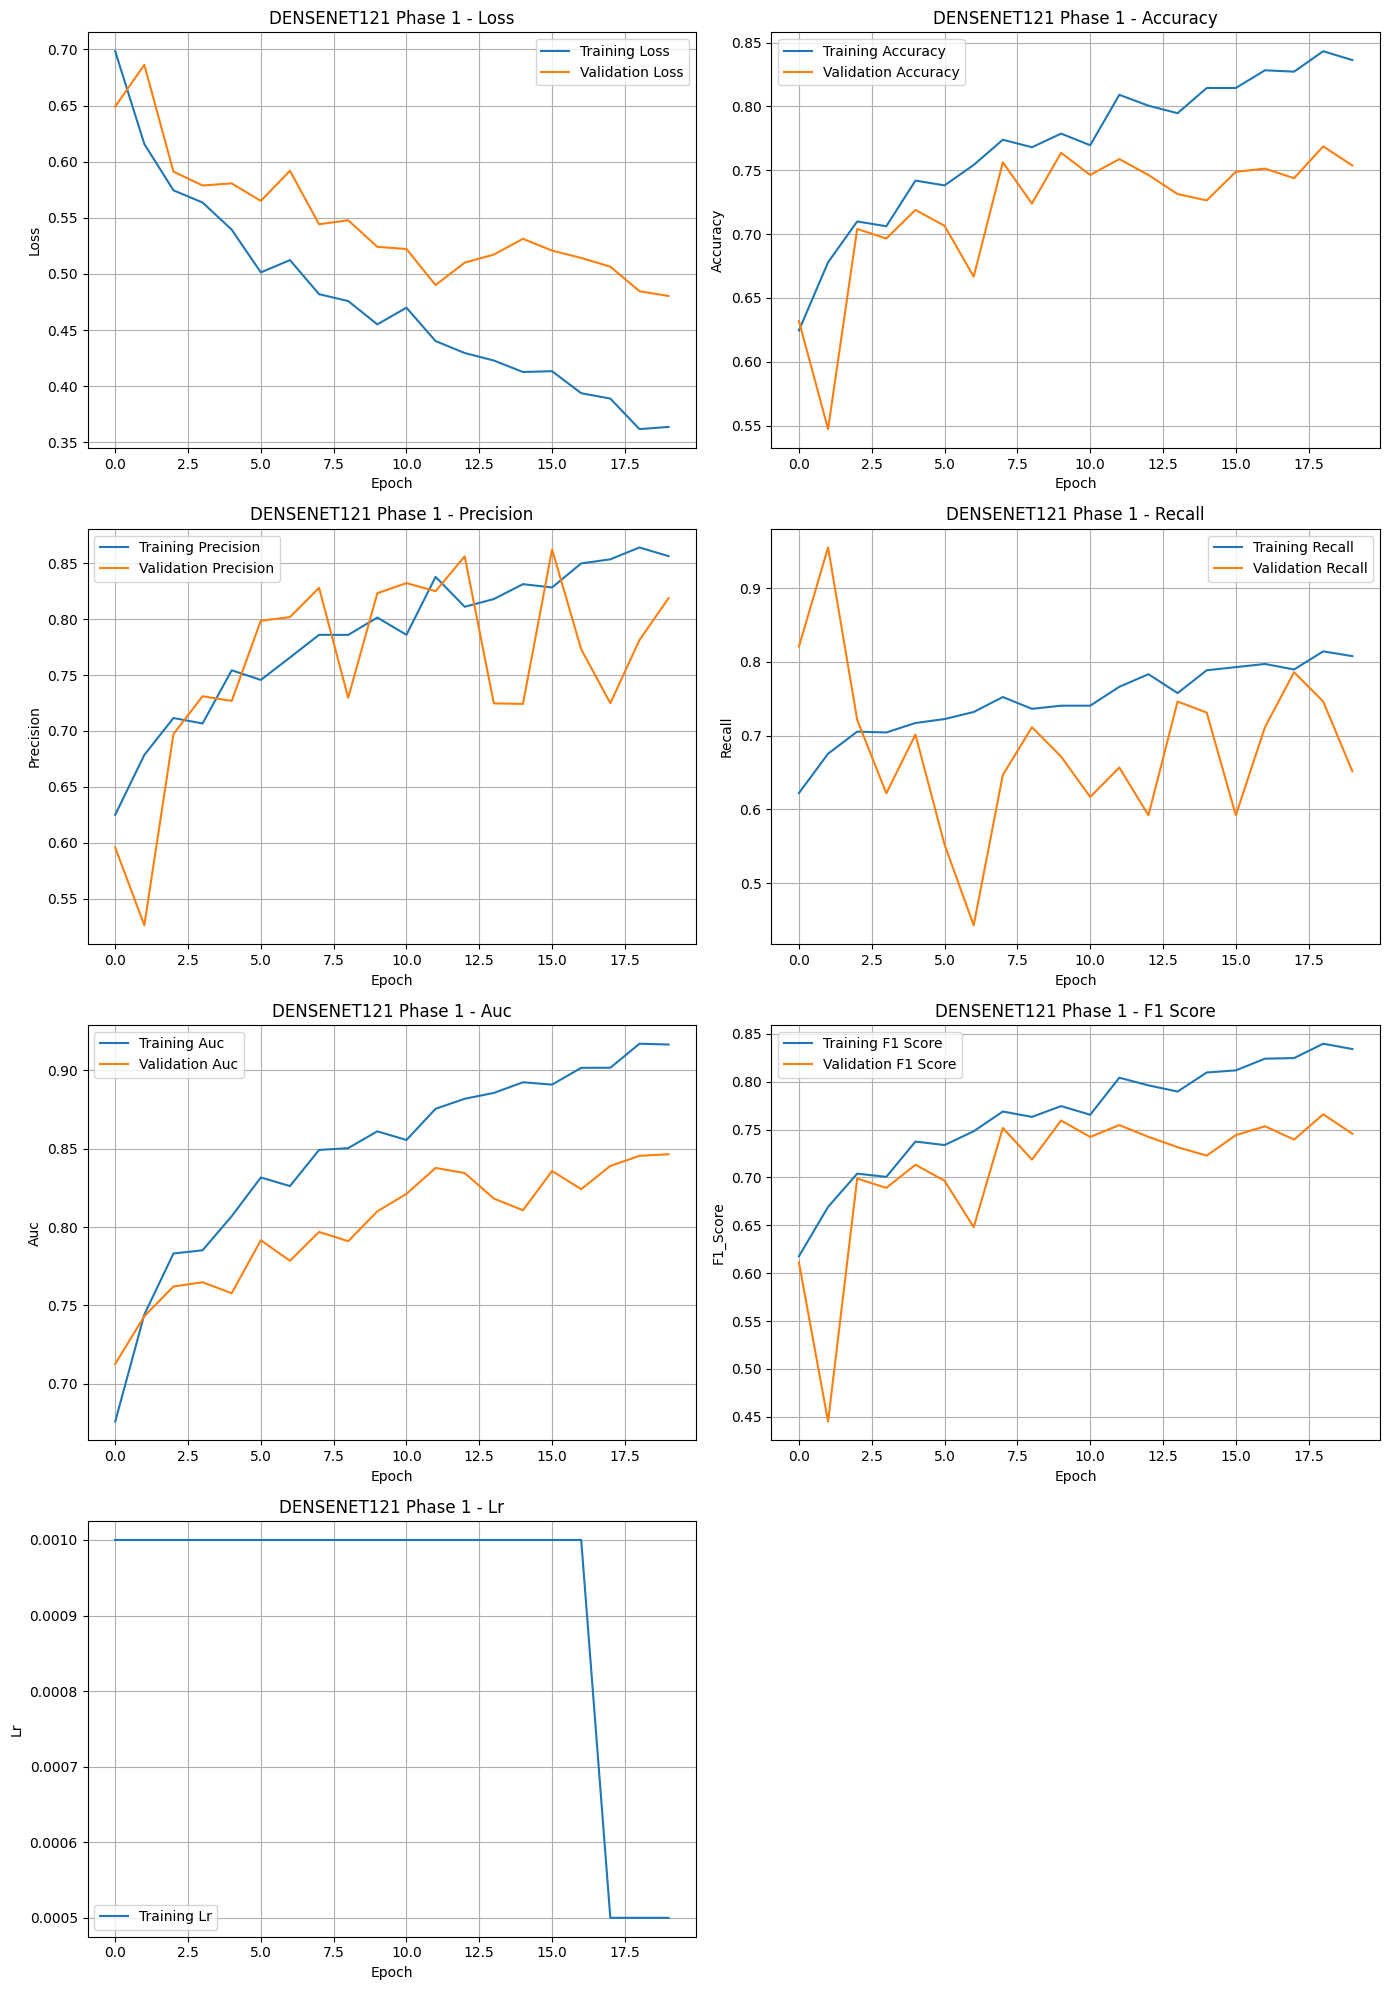

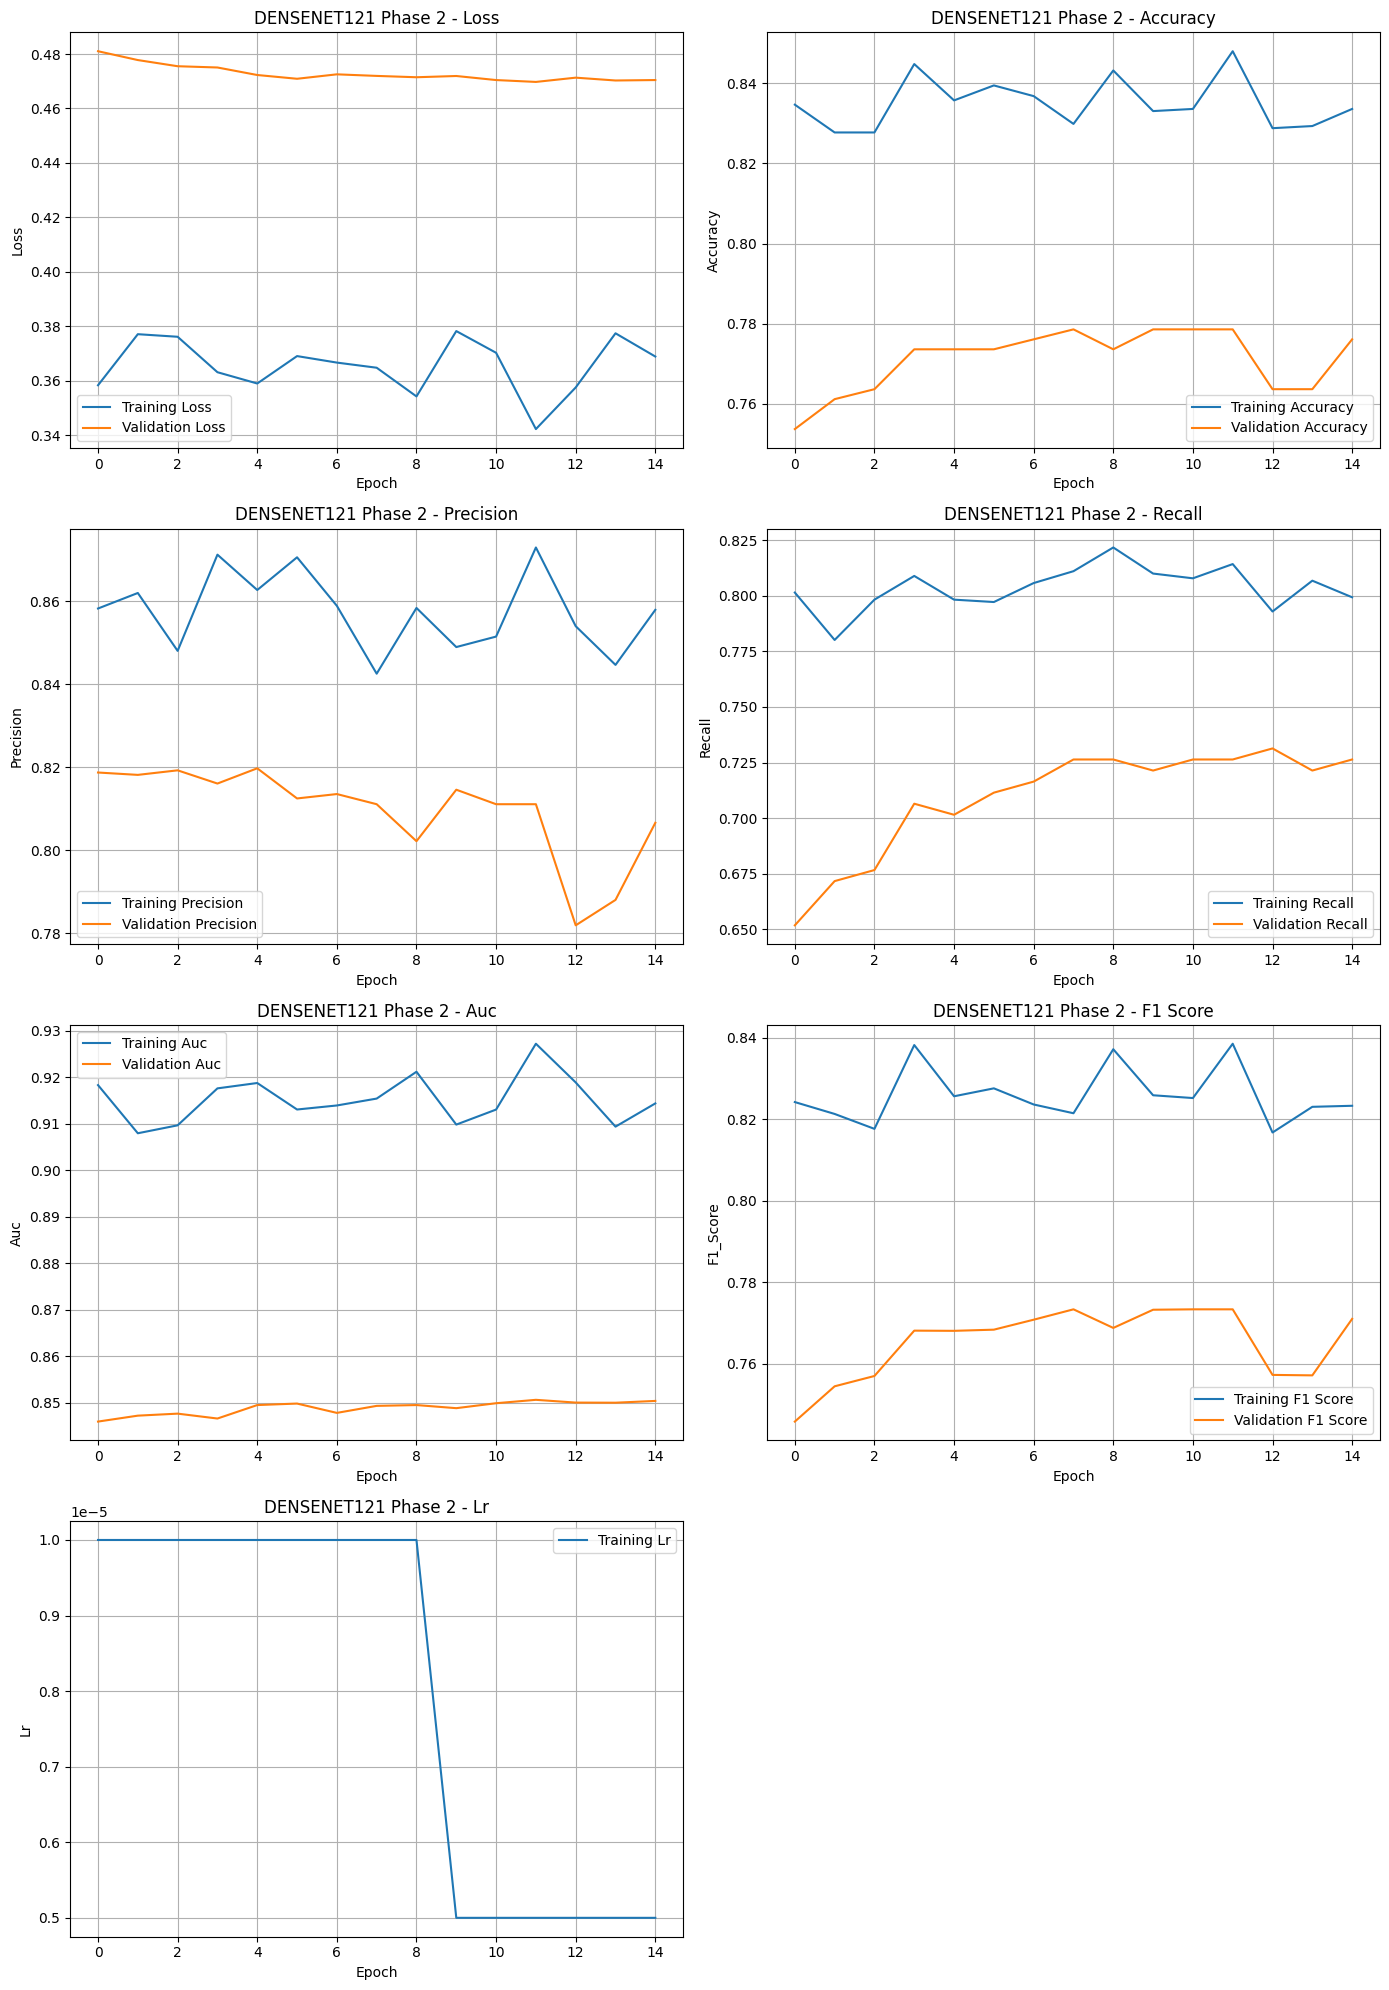


--- Training History for DENSENET201 ---


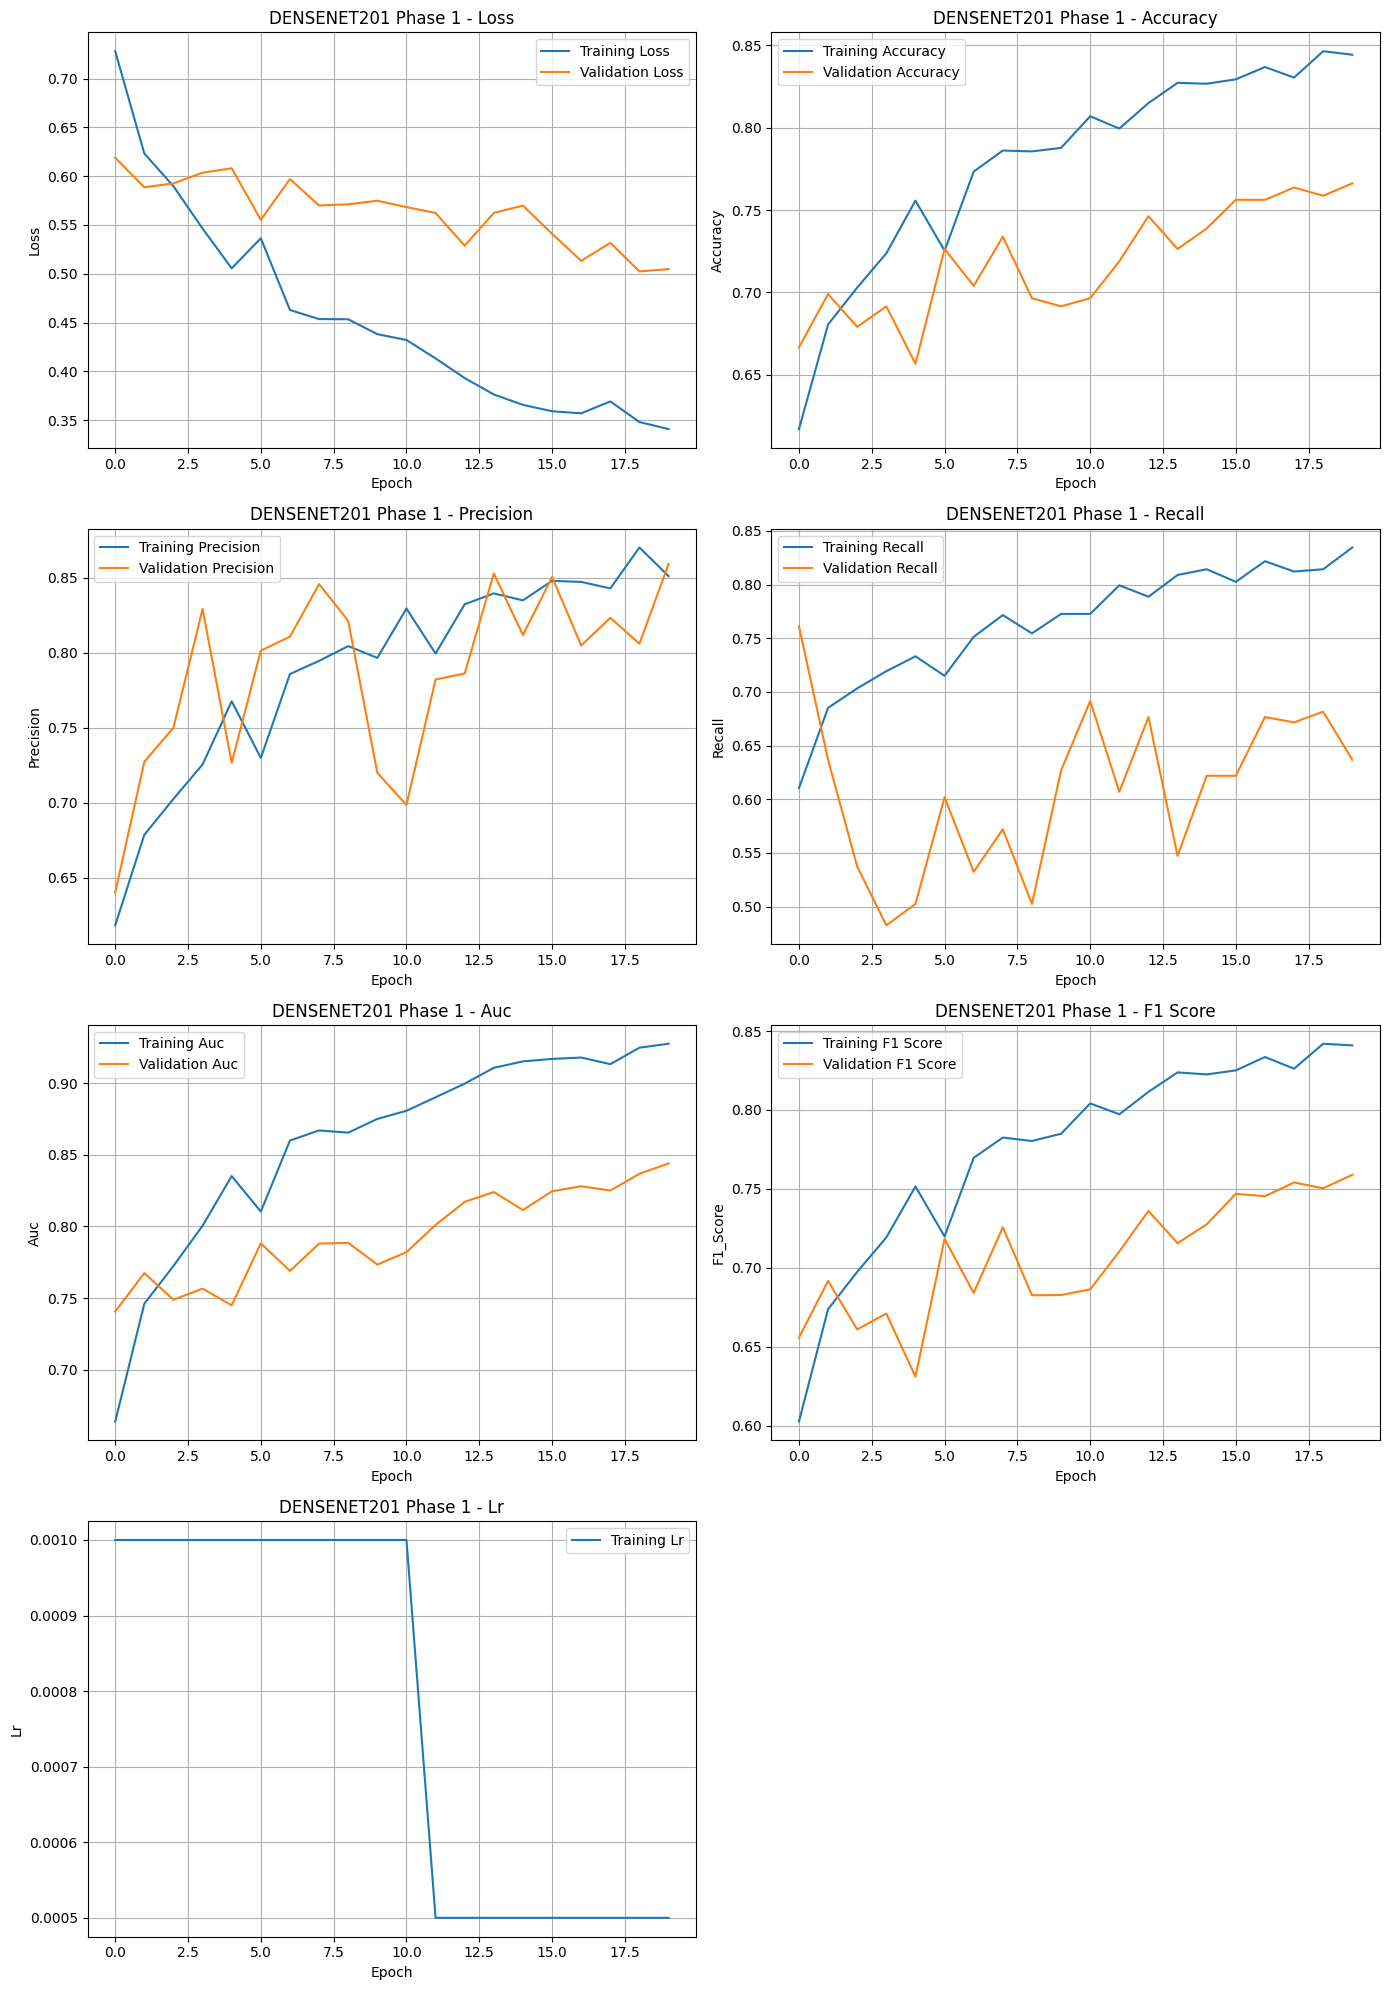

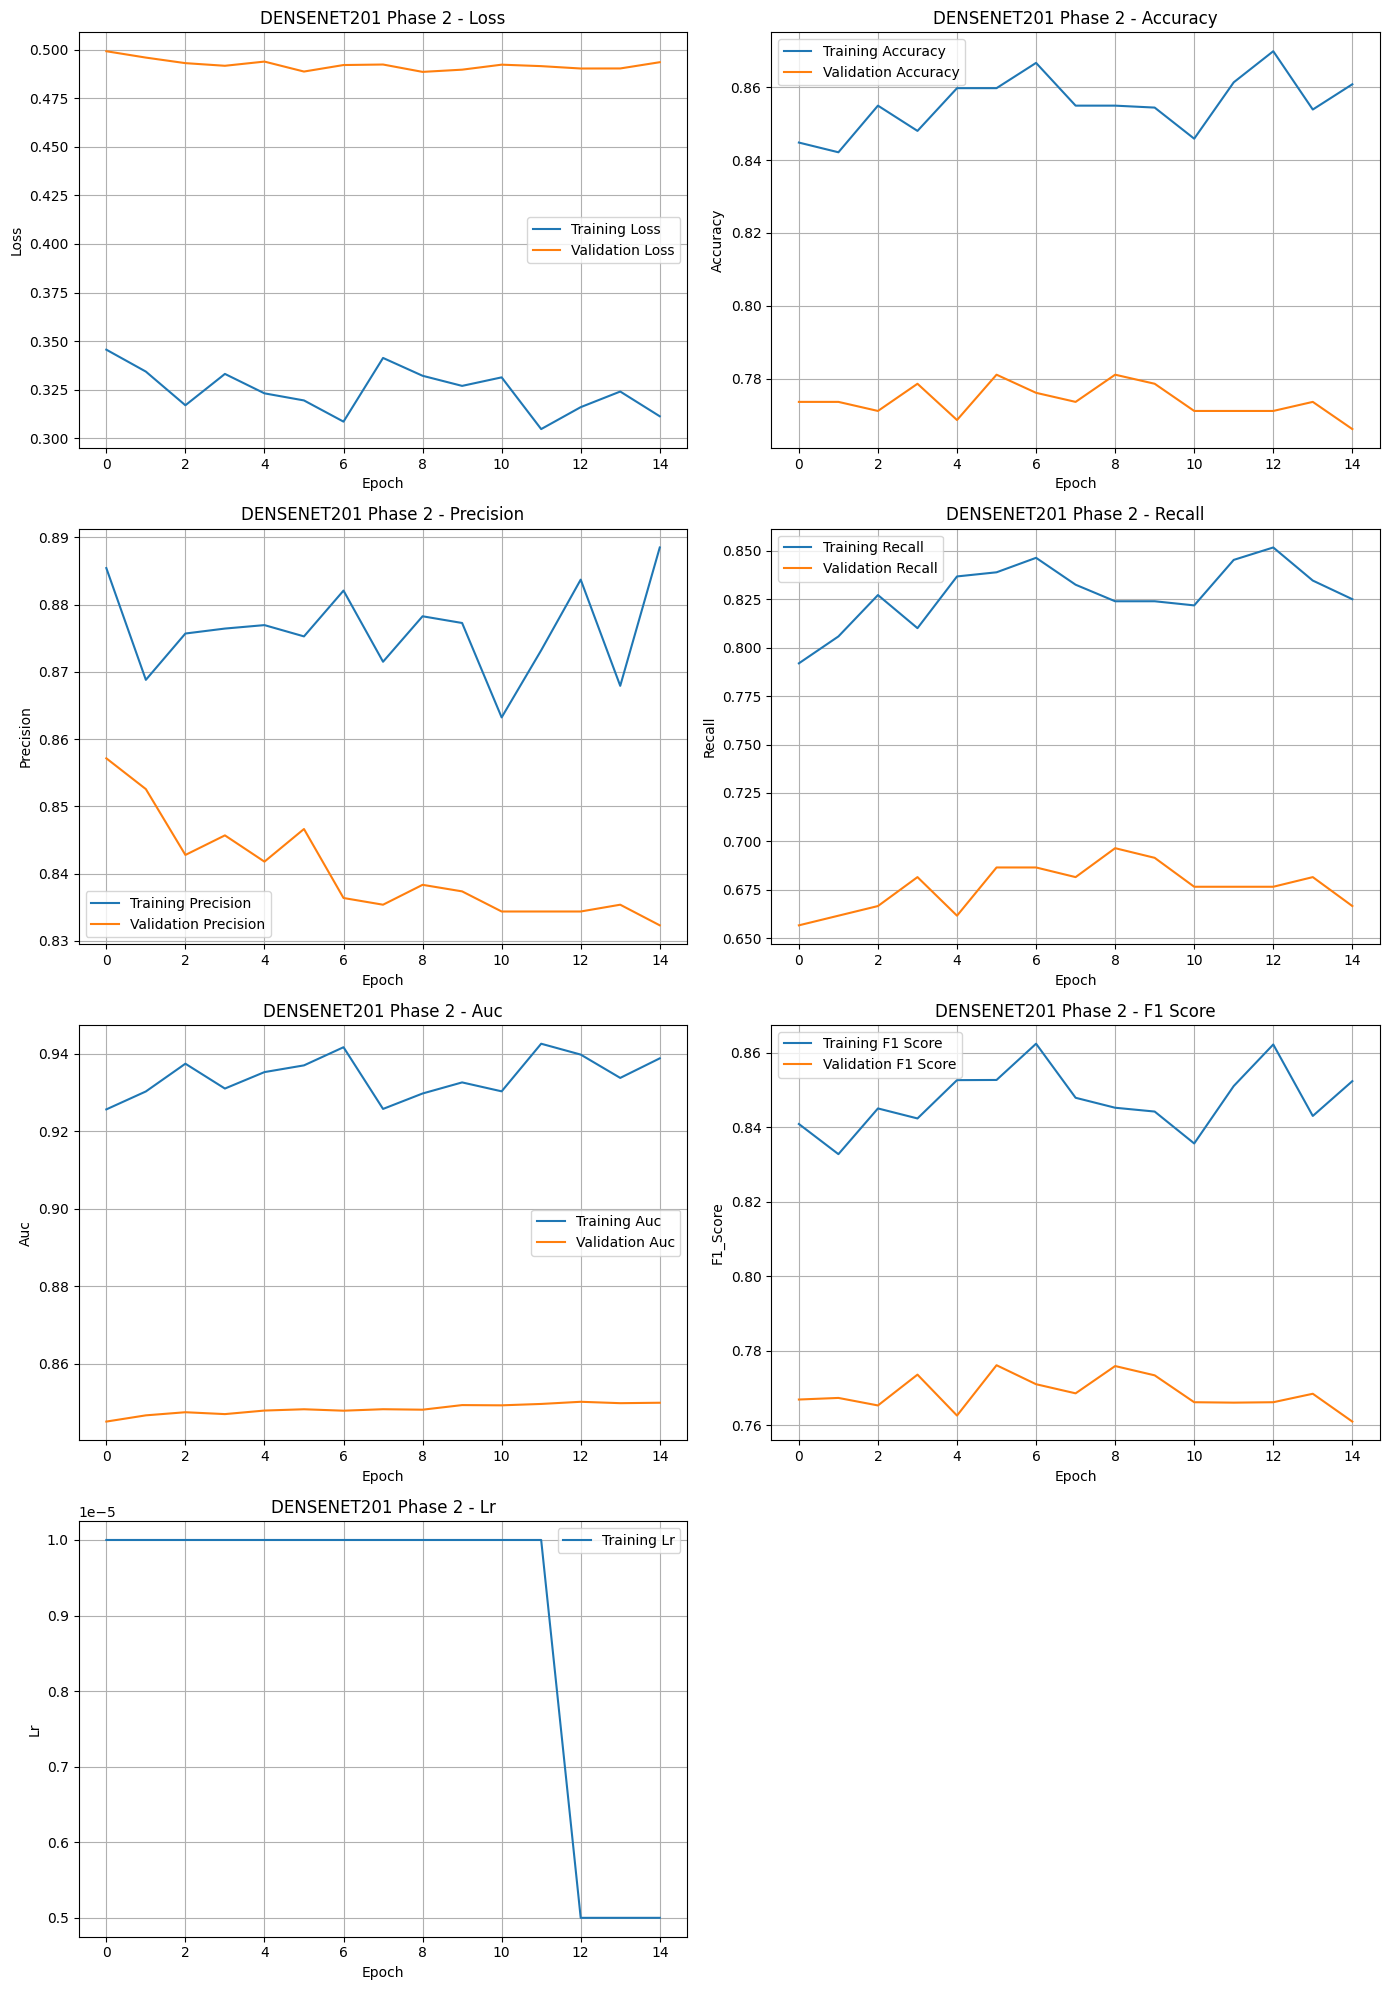

In [30]:
def plot_training_histories(history_dict, title_prefix=""):
    """
    Plots the training and validation metrics from a Keras history object.
    """
    import math
    
    # Get the metrics that were recorded
    metrics = [key for key in history_dict.keys() if not key.startswith('val_')]
    num_metrics = len(metrics)
    
    # Determine the layout of the plot
    cols = 2
    rows = math.ceil(num_metrics / cols)
    
    plt.figure(figsize=(7 * cols, 5 * rows))
    
    for i, metric in enumerate(metrics, 1):
        plt.subplot(rows, cols, i)
        
        # Plot training metric
        plt.plot(history_dict[metric], label=f"Training {metric.replace('_', ' ').title()}")
        
        # Plot validation metric if it exists
        val_metric = f"val_{metric}"
        if val_metric in history_dict:
            plt.plot(history_dict[val_metric], label=f"Validation {metric.replace('_', ' ').title()}")
        
        plt.title(f"{title_prefix} - {metric.replace('_', ' ').title()}")
        plt.xlabel("Epoch")
        plt.ylabel(metric.title())
        plt.legend()
        plt.grid(True)
        
    plt.tight_layout()
    plt.show()

# Loop through all results and plot the histories for both phases
for arch, results in all_results.items():
    print(f"\n--- Training History for {arch.upper()} ---")
    plot_training_histories(results['history_phase1'], title_prefix=f"{arch.upper()} Phase 1")
    plot_training_histories(results['history_phase2'], title_prefix=f"{arch.upper()} Phase 2")

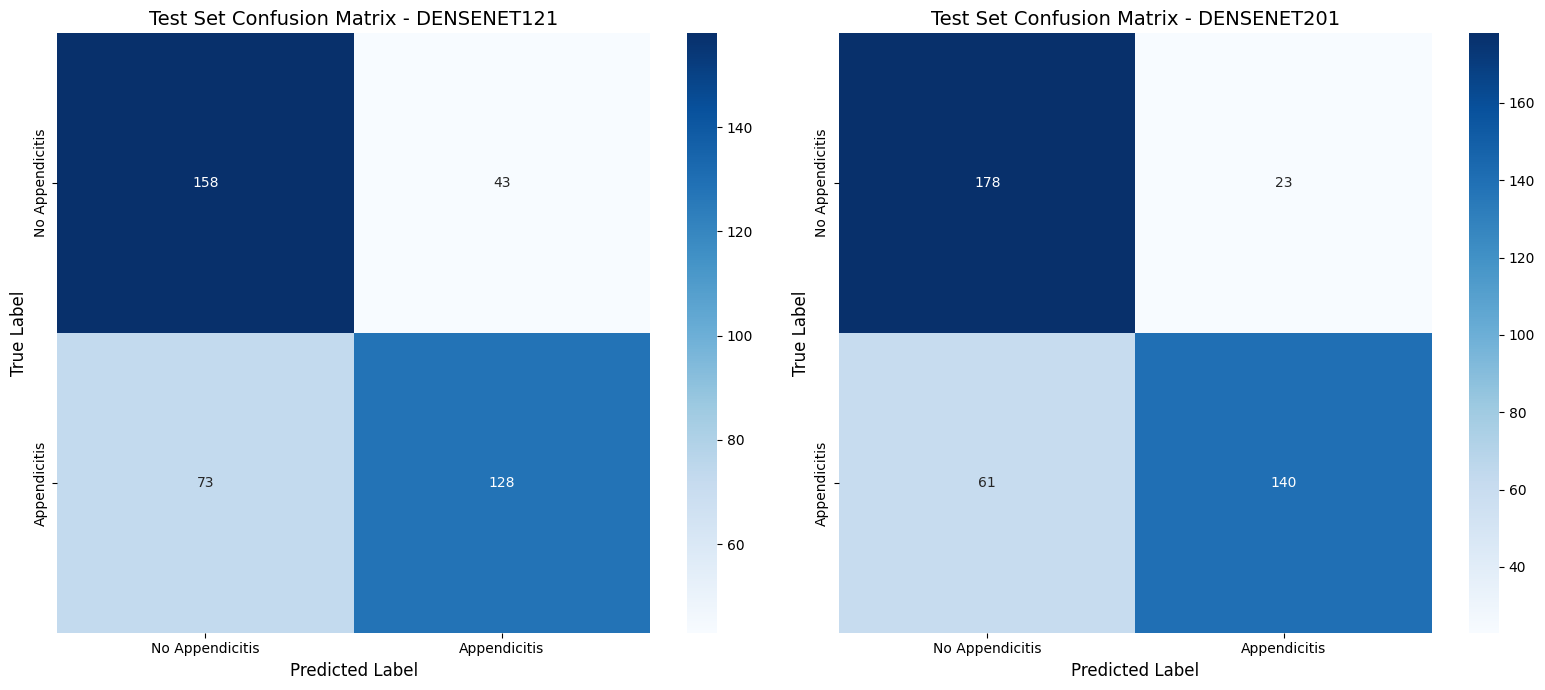

In [31]:
# --- Plotting Confusion Matrices for the Test Set ---

# Set the number of columns for our plot grid
num_models = len(all_results)
cols = 2
rows = (num_models + 1) // cols  # Calculate required rows

fig, axes = plt.subplots(rows, cols, figsize=(8 * cols, 7 * rows))
axes = axes.flatten() # Flatten the axes array for easy iteration

# Define the labels for the matrix axes
matrix_labels = ['No Appendicitis', 'Appendicitis']

# Loop through the results and plot the confusion matrix for each model
for i, (arch, results) in enumerate(all_results.items()):
    ax = axes[i]
    cm = results['test_evaluation']['confusion_matrix']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=matrix_labels,
                yticklabels=matrix_labels,
                ax=ax)
    
    ax.set_title(f'Test Set Confusion Matrix - {arch.upper()}', fontsize=14)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)

# Hide any unused subplots if the number of models is odd
for i in range(num_models, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Loading densenet121 from best_densenet121_phase2.keras ...


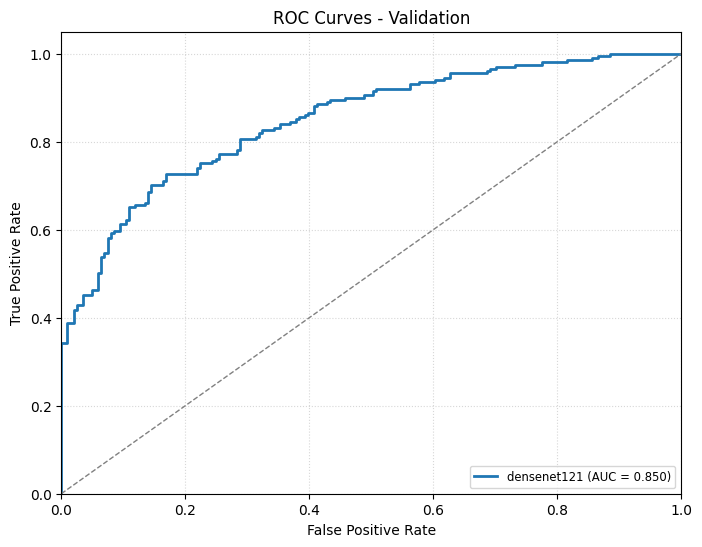

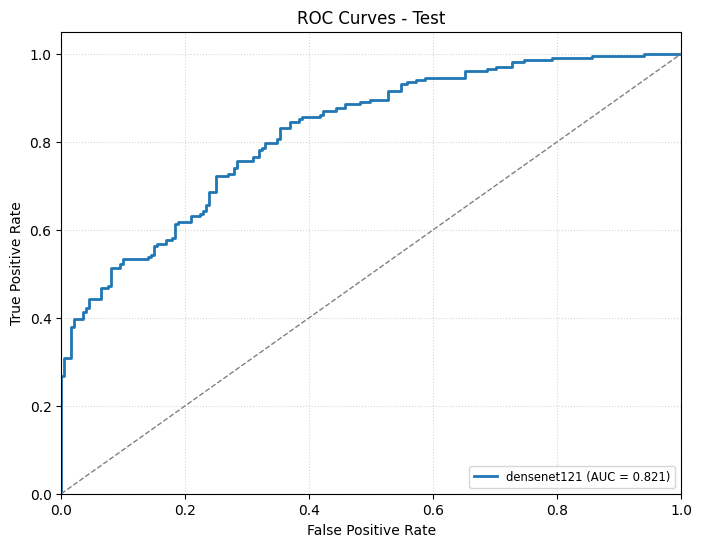

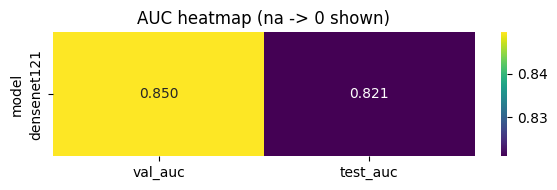

              val_auc  test_auc
model                          
densenet121  0.849583  0.821094


In [32]:
# Cell: Plot ROC / AUC for saved models (add to your notebook)
# Requires: sklearn, matplotlib, seaborn, pandas, tensorflow (already used in your notebook)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# If you have a custom f1_score metric in the model, pass it here when loading
# (copy the function from your notebook)
import tensorflow.keras.backend as K
def f1_score(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        return true_positives / (predicted_positives + K.epsilon())

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def safe_load_model(path):
    """Try to load model with custom_objects if needed."""
    try:
        return load_model(path)
    except Exception as e:
        # try with f1_score in custom objects (common issue if saved with custom metric)
        try:
            return load_model(path, custom_objects={'f1_score': f1_score})
        except Exception:
            # Last fallback: raise the original exception
            raise e

def plot_roc_single(y_true, y_score, label=None, ax=None):
    """Plot single ROC curve and return AUC value."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {roc_auc:.3f})" if label else f"AUC = {roc_auc:.3f}")
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.grid(True, linestyle=':', alpha=0.5)
    return roc_auc

def plot_rocs_for_models(model_paths, X_val, y_val, X_test=None, y_test=None,
                         set_labels=('Validation', 'Test'), figsize=(8,6), save_path=None):
    """
    model_paths: dict-like {arch_name: path_to_saved_model}
    X_val, y_val: validation data arrays (numpy)
    X_test, y_test: optional test data arrays
    Returns: DataFrame with AUCs (rows=models, cols=['val_auc','test_auc'])
    """
    auc_records = []
    # Create a combined ROC figure for validation
    fig_val, ax_val = plt.subplots(figsize=figsize)
    if X_test is not None and y_test is not None:
        fig_test, ax_test = plt.subplots(figsize=figsize)
    else:
        fig_test = ax_test = None

    for arch_name, model_path in model_paths.items():
        print(f"Loading {arch_name} from {model_path} ...")
        model = safe_load_model(model_path)

        # predict returns probabilities because final activation is sigmoid
        val_scores = model.predict(X_val, verbose=0).ravel()
        val_auc = plot_roc_single(y_val, val_scores, label=arch_name, ax=ax_val)

        test_auc = np.nan
        if X_test is not None and y_test is not None:
            test_scores = model.predict(X_test, verbose=0).ravel()
            test_auc = plot_roc_single(y_test, test_scores, label=arch_name, ax=ax_test)

        auc_records.append({'model': arch_name, 'val_auc': val_auc, 'test_auc': test_auc})

    ax_val.set_title(f"ROC Curves - {set_labels[0]}")
    ax_val.legend(loc='lower right', fontsize='small')
    if fig_test:
        ax_test.set_title(f"ROC Curves - {set_labels[1]}")
        ax_test.legend(loc='lower right', fontsize='small')

    if save_path:
        fig_val.savefig(f"{save_path}_val_roc.png", dpi=200, bbox_inches='tight')
        if fig_test:
            fig_test.savefig(f"{save_path}_test_roc.png", dpi=200, bbox_inches='tight')
    plt.show()

    auc_df = pd.DataFrame(auc_records).set_index('model')
    # If you want a heatmap of AUCs:
    plt.figure(figsize=(6, max(2, 0.5 * len(auc_df))))
    sns.heatmap(auc_df[['val_auc','test_auc']].fillna(0), annot=True, fmt=".3f", cmap='viridis')
    plt.title("AUC heatmap (na -> 0 shown)")
    plt.tight_layout()
    if save_path:
        plt.savefig(f"{save_path}_auc_heatmap.png", dpi=200, bbox_inches='tight')
    plt.show()

    return auc_df

# Example usage (add this in a cell after training / evaluation):
# Make sure the saved models exist at these paths (your notebook saves them as best_{arch}_phase2.keras)
model_paths = {
    'densenet121': 'best_densenet121_phase2.keras',
    # 'densenet201': 'best_densenet201_phase2.keras'
}

# X_val, y_val, X_test, y_test are already available in your notebook from earlier cells.
# If you only want validation plot, pass X_test=None, y_test=None
# Run:
auc_df = plot_rocs_for_models(model_paths, X_val, y_val, X_test, y_test, save_path='roc_out')
print(auc_df)

In [33]:
# Create a list to hold the detailed summary data for each model
summary_data = []

# Loop through the results to calculate and extract final test performance
for arch, results in all_results.items():
    test_eval = results['test_evaluation']
    cm = test_eval['confusion_matrix']
    tn, fp, fn, tp = cm.ravel()

    # Calculate basic metrics from the confusion matrix components
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)  # This is the same as sensitivity
    
    # Get the new metrics from the evaluation results
    f1_class_0 = test_eval.get('f1_class_0', 0)  # F1 for No Appendicitis
    f1_class_1 = test_eval.get('f1_class_1', 0)  # F1 for Appendicitis
    f1_macro = test_eval.get('f1_macro', 0)      # Macro F1 (average of both)
    auc_score = test_eval.get('auc', 0)          # AUC
    
    # Specificity was already calculated and stored
    specificity = test_eval.get('specificity', tn / (tn + fp + 1e-7))

    summary_data.append({
        "Architecture": arch.upper(),
        "Accuracy": f"{accuracy:.3f}",
        "Sensitivity (Recall)": f"{recall:.3f}",
        "Specificity": f"{specificity:.3f}",
        "F1 (No Appendicitis)": f"{f1_class_0:.3f}",
        "F1 (Appendicitis)": f"{f1_class_1:.3f}",
        "F1 (Macro Avg)": f"{f1_macro:.3f}",
        "AUC": f"{auc_score:.3f}",
    })

# Create a pandas DataFrame from the summary data
summary_df = pd.DataFrame(summary_data)

# Display the final, more detailed summary table
print("\n" + "="*80)
print("--- Final Model Performance on Test Set ---")
print("="*80)
print(summary_df.to_string(index=False))
print("="*80)


--- Final Model Performance on Test Set ---
Architecture Accuracy Sensitivity (Recall) Specificity F1 (No Appendicitis) F1 (Appendicitis) F1 (Macro Avg)   AUC
 DENSENET121    0.711                0.637       0.786                0.731             0.688          0.710 0.824
 DENSENET201    0.791                0.697       0.886                0.809             0.769          0.789 0.873
